In [1]:
### Useful libraries
import numpy as np
import astropy.units as u
from astropy.io import fits 
#### Modules within our library
import M2_ProposalTools.WorkHorse as WH
import M2_ProposalTools.MakeRMSmap as MRM
import M2_ProposalTools.ModelFitting as MF

In [4]:
outdir="/home/data/MUSTANG2/SimulatedObservations/QuickAndDirty/"

In [5]:
M5_14    = 6.0
M500     = M5_14*1e14*u.M_sun
z        = 0.5
pixsize  = 4.0

times    = [10,10]
ptgs     = [[180,45.0],[180,45.0]]
sizes    = [3.5,3.5]
offsets  = [1.5,0]

In [44]:
FilterHDU,SmoothHDU,SkyHDU = WH.lightweight_simobs_A10(z,M500,conv2uK=True,pixsize=pixsize,ptgs=ptgs,sizes=sizes,times=times,offsets=offsets,Dist=True)

hi


/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/MakeRMSmap.py:591: RuntimeWarning: invalid value encountered in true_divide
  NewImg     = (img1*wtm1 + img2*wtm2)/NewWtm
/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/MakeRMSmap.py:591: RuntimeWarning: invalid value encountered in true_divide
  NewImg     = (img1*wtm1 + img2*wtm2)/NewWtm
/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/MakeRMSmap.py:591: RuntimeWarning: invalid value encountered in true_divide
  NewImg     = (img1*wtm1 + img2*wtm2)/NewWtm
/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/MakeRMSmap.py:591: RuntimeWarning: invalid value encountered in true_divide
  NewImg     = (img1*wtm1 + img2*wtm2)/NewWtm
/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/MakeRMSmap.py:591: RuntimeWarning: invalid value encountered in true_divide
  NewImg     = (img1*wtm1 + img2*wtm2)/NewWtm


In [7]:
pixstr = "{:.1f}".format(pixsize).replace(".","p")
zstr   = "{:.1f}".format(z).replace(".","z")
Mstr   = "{:.1f}".format(M5_14).replace(".","m")
sss    = ["{:.1f}".format(mysz).replace(".","s") for mysz in sizes]
sts    = ["{:.1f}".format(mytime).replace(".","h") for mytime in times]
ssstr  = "_".join(sss)
ststr  = "_".join(sts)
InputStr = "_".join([zstr,Mstr,ssstr,ststr,pixstr])

filename = "SimulatedObs_Unsmoothed_"+InputStr+".fits"
FilterHDU.writeto(outdir+filename,overwrite=True)
filename2 = "SimulatedObs_Smoothed_"+InputStr+".fits"
SmoothHDU.writeto(outdir+filename2,overwrite=True)
filename3 = "SimulatedSky_"+InputStr+".fits"
SkyHDU.writeto(outdir+filename3,overwrite=True)

In [8]:
SkyHDU[0].data *= -3.3e6 # Run once 


In [43]:
WH=reload(WH)
MRM=reload(MRM)
MF=reload(MF)

131.5 131.5
131.5 131.5
131.5 131.5


/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/ModelFitting.py:798: RuntimeWarning: divide by zero encountered in true_divide
  UncPerBin       = 1.0/ np.sqrt( WMy*bmCnt )


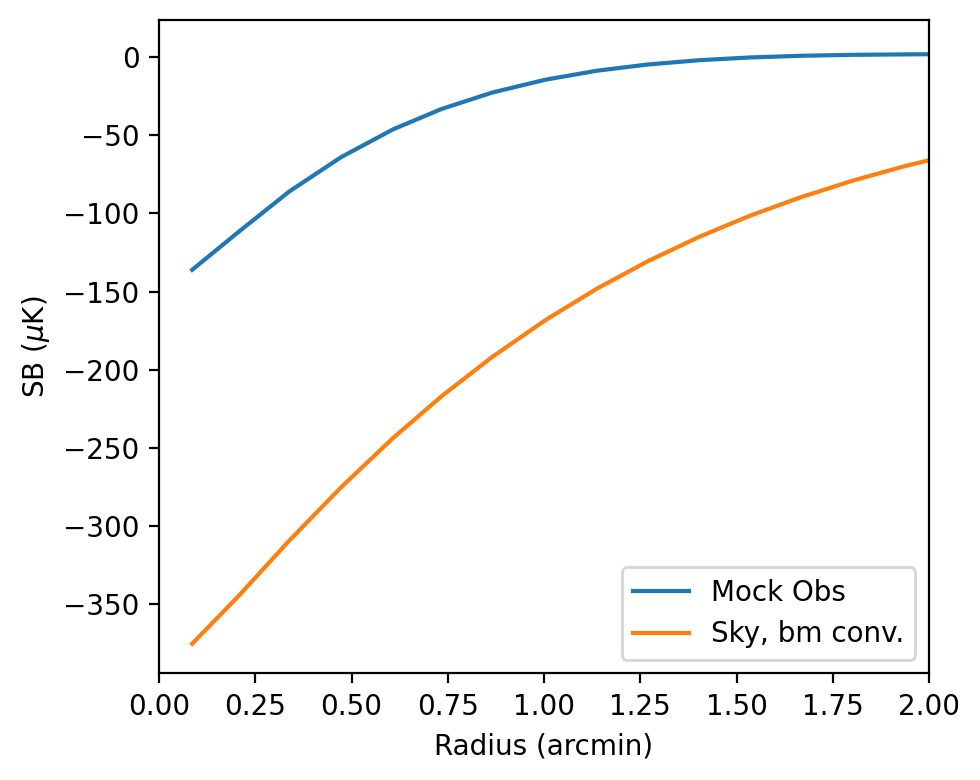

In [10]:
SBfn = "SimulatedObs_SBprofiles_"+InputStr+".png"
MF.plot_SB_profiles(FilterHDU,SkyHDU,outdir,SBfn,solns=None,bv=120.0,prntPk=True)

In [11]:
pngname  = "SimulatedObservations_"+InputStr+"_RMSimage.png"
vmin     = 15.0  # uK
vmax     = 420.0 # uK
MRM.plot_rms_general(SmoothHDU,outdir+pngname,ncnts=5,vmin=vmin,vmax=vmax)

/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/MakeRMSmap.py:15: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("tab20b").copy()
  mycmap.set_under('w')
/home/charles/Python/ForGitHub/M2_TJ/src/M2_ProposalTools/MakeRMSmap.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("tab20b").copy()
  mycmap.set_over('w')


144 0 32 113 263.0 15
I already did this


<Figure size 504x360 with 0 Axes>